<a href="https://colab.research.google.com/github/hyunwook-lee/-/blob/master/7days_lstm_dqn_DP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow as tf
from google.colab import drive
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from tensorflow.keras import layers
from sklearn import preprocessing

import os


# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##데이터 입력


In [ ]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Colab_data/df_dropna_3456.csv') 

print(df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


         Unnamed: 0 CORP_ID  ...         INS_DATETIME          INS-BKG
0                 1   KX007  ...  2021-03-03 13:14:25  0 days 09:19:04
1                 2   KX007  ...  2021-03-03 13:14:25  0 days 09:19:12
2                 3   KX007  ...  2021-03-03 13:14:25  0 days 09:18:17
3                 4   KX007  ...  2021-03-03 13:14:25  0 days 09:18:34
4                 5   KX007  ...  2021-03-03 13:14:25  0 days 09:18:34
...             ...     ...  ...                  ...              ...
1585519     1786343   KX007  ...  2021-07-02 10:14:25  1 days 21:54:24
1585520     1786347   KX007  ...  2021-07-02 12:22:03  2 days 23:53:51
1585521     1786348   KX007  ...  2021-07-03 22:01:52  3 days 21:58:56
1585522     1786349   KX007  ...  2021-07-04 05:50:47  3 days 15:19:29
1585523     1786354   KX007  ...  2021-07-03 00:14:24  3 days 01:39:21

[1585524 rows x 41 columns]


In [ ]:
df_dropna = df
df_dropna["INS_DATETIME"] = pd.to_datetime(df_dropna["INS_DATETIME"])
df_dropna["BKG_DATETIME"] = pd.to_datetime(df_dropna["BKG_DATETIME"])

df_dropna["INS-BKG"] = df_dropna["INS_DATETIME"] - df_dropna["BKG_DATETIME"]
df_dropna["INS-BKG"].dtype

df_dropna['secs']=df_dropna['INS-BKG'].dt.total_seconds()

In [ ]:
df_dropna["SHPR_CD"] = df_dropna["SHPR_CD"].astype(str)
df_dropna["SHPR_CD"].value_counts()
data_df = pd.DataFrame(data = {'쇼핑몰 수': [2], '아이템 합' : [3], 'Count': [4]})

#예측에서 사용할 인자 추출
def makeDataToTimeseries(df):
    timeseries_df = pd.DataFrame()
    timeseries_df['Date'] = df.BKG_DATE.unique()
    timeseries_df['Date'] = timeseries_df['Date']
    print(timeseries_df)
    timeseries_df['ItmeCount'] = timeseries_df.Date.map(lambda x: len(df.query(f' BKG_DATE == "{x}"').ITEM_CD.unique()))
    print(timeseries_df)
    timeseries_df['MallCount'] = timeseries_df.Date.map(lambda x: len(df.query(f' BKG_DATE == "{x}"').SHPR_CD.unique()))
    print(timeseries_df)
    timeseries_df['TotalCount'] = timeseries_df.Date.map(lambda x: df.query(f' BKG_DATE == "{x}"').shape[0])
    print(timeseries_df)
    timeseries_df['Total_Sconds'] = timeseries_df.Date.map(lambda x: sum(df.query(f' BKG_DATE == "{x}"').secs))
    print(timeseries_df)

    return timeseries_df

timedf = makeDataToTimeseries(df_dropna)
print(timedf)


                    Date
0    2021-03-03 00:00:00
1    2021-03-01 00:00:00
2    2021-03-02 00:00:00
3    2021-03-04 00:00:00
4    2021-03-05 00:00:00
..                   ...
117  2021-06-24 00:00:00
118  2021-06-26 00:00:00
119  2021-06-27 00:00:00
120  2021-06-25 00:00:00
121  2021-06-30 00:00:00

[122 rows x 1 columns]
                    Date  ItmeCount
0    2021-03-03 00:00:00       1746
1    2021-03-01 00:00:00       1620
2    2021-03-02 00:00:00       1697
3    2021-03-04 00:00:00       1570
4    2021-03-05 00:00:00       1318
..                   ...        ...
117  2021-06-24 00:00:00       3303
118  2021-06-26 00:00:00       3005
119  2021-06-27 00:00:00       3659
120  2021-06-25 00:00:00       3214
121  2021-06-30 00:00:00       3553

[122 rows x 2 columns]
                    Date  ItmeCount  MallCount
0    2021-03-03 00:00:00       1746          8
1    2021-03-01 00:00:00       1620          8
2    2021-03-02 00:00:00       1697          8
3    2021-03-04 00:00:00       1

In [ ]:
#Date 추가 로직
timedf["Date"] = pd.to_datetime(timedf.Date)
timedf.sort_values(by='Date', inplace=True)
timedf

total_count_list = list(timedf["ItmeCount"])
for x in range(len(total_count_list)-1):
    if x != len(total_count_list)-1:
        total_count_list[x] = total_count_list[x+1] - total_count_list[x]
    else:
        total_count_list[x+1] = 0
for x in range(len(total_count_list)):
    if x == 0:
        total_count_list.pop()
        total_count_list.insert(0,0)
df = pd.DataFrame({"item_count_dif" : total_count_list})

timedf.insert(2,"item_count_dif",df)
timedf

In [ ]:
# 정규화
scaler = preprocessing.MinMaxScaler()
# scaler_fit = scaler.fit()
#, ,'ItmeCount', 'MallCount', 'item_count_dif'
scale_cols = ['TotalCount']
df_scaled = scaler.fit_transform(timedf[scale_cols])


scaled = scaler.fit_transform(timedf[['TotalCount']])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled

In [ ]:
# 7일 예측 로직

TEST_SIZE = 60
train = df_scaled[:-TEST_SIZE].astype(float)
test = df_scaled[-TEST_SIZE:].astype(float)

def make_train_dataset(data, label, window_size=7):
    feature_list = []
    label_list = []
    for i in range(0,len(data) - (window_size*2), 7):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size:i+window_size+window_size]))
    return np.array(feature_list), np.array(label_list)
def make_test_dataset(data, label, window_size=7):
    feature_list = []
    label_list = []
    for i in range(0,len(data) - (window_size*2)):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size:i+window_size+window_size]))
    return np.array(feature_list), np.array(label_list)

#TotalCount로만 예측
feature_cols = ['TotalCount']
label_cols = ['TotalCount']

train_feature = train[feature_cols]
train_label = train[label_cols]

test_feature, test_label = test[feature_cols], test[label_cols]

# train dataset
train_feature, train_label = make_train_dataset(train_feature, train_label)

print(train_feature)
# train set 생성
# x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
# print(x_train)
x_train = train_feature
y_train = train_label
# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_test_dataset(test_feature, test_label)
test_feature.shape, test_label.shape


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 50)             10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 7)                 357       
Total params: 30,957
Trainable params: 30,957
Non-trainable params: 0
_________________________________________________________________


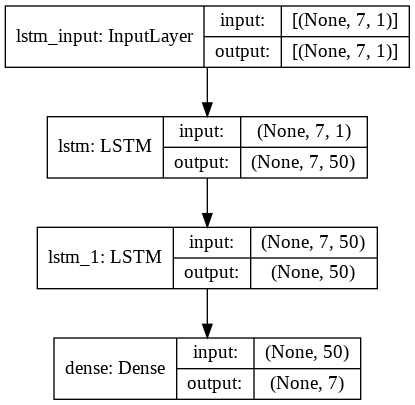

<Figure size 288x72 with 0 Axes>

In [ ]:
#모델 생성
model = Sequential()
model.add(LSTM(units = 50, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='tanh', return_sequences = True,
               )
          )
model.add(LSTM(units = 50, activation = 'tanh'))
# model.add(Dense(32))
model.add(Dense(7))
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model

%matplotlib inline

plt.figure(figsize=(4,1))
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

plot_model(model, to_file='model.png')
plot_model(model, to_file='model_shapes.png', show_shapes=True)

In [ ]:
#모델 compile
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=80)
filename = os.path.join("/a/b/c", 'tmp_checkpoint.h5')
history = model.fit(x_train, y_train, epochs=3000,batch_size=1)

In [ ]:
pred = model.predict(test_feature)
#pred 전처리 7개 예측을 Graph로 확인하기 위함
pred_graph = []
for x in range(len(pred)):
    if x == len(pred) -1:
        for i in range(7):
            pred_graph.append(pred[x][i])
    pred_graph.append(pred[x][1])
for x in range(len(pred_graph)):
    if pred_graph[x] > 1:
        pred_graph[x] = 1
    elif pred_graph[x] < 0:
        pred_graph[x] = 0


In [ ]:
#그래프로 확인후 정규화 -> 역규화를 통한 7일 가격 예측 q_0로 사용될 값
plt.figure(figsize=(12, 9))
pred_inverse = scaler.inverse_transform(np.array(pred).reshape(-1,1))
b = test_label
actual_graph = []
for x in range(len(b)):
    actual_graph.append(b[x][0])

plt.plot(actual_graph, label='actual')
plt.plot(pred_graph, label='prediction')
plt.xlabel("time")
plt.legend()
plt.show()
prediction_7days = pred_inverse[-7:]
prediction_7days = list(prediction_7days.reshape(-1))
print(prediction_7days)
prediction_7days = [17301.336, 22815.393, 10638.449, 4188.1777, 11066.61, 14206.219, 8009.828]
for x in range(len(prediction_7days)):
    prediction_7days[x] = int(prediction_7days[x])

# DQN

In [ ]:
import math 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-white')
import pandas as pd
from matplotlib import animation, rc
plt.rcParams.update({'pdf.fonttype': 'truetype'})

from bokeh.io import show, output_notebook
from bokeh.palettes import PuBu4
from bokeh.plotting import figure
from bokeh.models import Label

import math
import random
import numpy as np
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.optim as optim

# from qbstyles import mpl_style
# mpl_style(dark=False)

In [ ]:
## Environment simulator
result_demand = []
def plus(x):
    return 0 if x < 0 else x
def minus(x):
    return 0 if x > 0 else -x
def shock(x): #(충격함수는 가격 변화에 따른 수요영향력)
    return np.sqrt(x) 
#변화 수요량
def q_t(p_t, p_t_1, q_0, k, a, b, q_setting, count=0):
    d_1 = plus(q_0[q_setting] - a*shock(plus(p_t - p_t_1)) + b*shock(minus(p_t - p_t_1)))
    #demand의 최대,최소 범위 설정
    if d_1 + 2000 < min(q_0):
        d_1 = q_0[q_setting] - min(q_0)
    elif  d_1 > max(q_0) + 2000:
        d_1 = q_0[q_setting] + min(q_0)
    if count == 1:
        #결과demand를 확인하기 위한 값
        result_demand.append(d_1)
    return  d_1
# t시점 이익
def profit_t(p_t, p_t_1, q_0, k, a, b, unit_cost, q_setting, count=0):
    return q_t(p_t, p_t_1, q_0, k, a, b, q_setting, count)*(p_t - unit_cost) #q_t(,,,) 이거는 demand임. #(p_t - unit_cost)는 순이익임(가격-유닛당 비용) 즉, 리턴값(profit) = 수요 * 순이익
# 이익의 총합
def profit_total(p, unit_cost, q_0, k, a, b, count=0):
    return profit_t(p[0], p[0], q_0, k, 0, 0, unit_cost, 0, count) + sum(map(lambda t: profit_t(p[t], p[t-1], q_0, k, a, b, unit_cost, t, count), range(len(p))))

def demand_check(demand):
    if demand + 2000 < min(q_0):
        return  min(q_0)
    elif demand > max(q_0) + 5000:
        return max(q_0)

## Environment parameters
T = 7
price_max = 2501
price_step = 100
#q_0 = prediction_7days -> 예측한 7일의 수요
k = 1
q_0 = prediction_7days
p_minus = 2000
unit_cost = 1000
a_q = 800
b_q = 800
count = 0

## Partial bindings for readability
def profit_t_response(p_t, p_t_1):
    return profit_t(p_t, p_t_1, q_0, k, a_q, b_q, unit_cost, 0) #택배 도메인에 맞춰서 들어가야 하는 상수.

def profit_response(p, count=0):
    return profit_total(p, unit_cost, q_0, k, a_q, b_q, count)

def profit_response_result(p, count):
    count += 1
    print(count)
    return profit_total(p, unit_cost, q_0, k, a_q, b_q, count)

def profit_response_dqn(p_t, p_t_1, t):
    return profit_t(p_t, p_t_1, q_0, k, a_q, b_q, unit_cost, t)

## Visualize price-demand functions
price_grid = np.arange(1500, price_max, price_step) ## price_step: 최소가격, 뒤 price_step: 가격 간격
price_change_grid = np.arange(0.5, 2.0, 0.1) ## [0.5, 0.6, 0.7 ,,, 1.9]
profit_map = np.zeros( (len(price_grid), len(price_change_grid)) ) #행 : price_gird 개수, 열 : price_change_grid 개수

for i in range(len(price_grid)):
    for j in range(len(price_change_grid)):
        profit_map[i,j] = profit_t_response(price_grid[i], price_grid[i]*price_change_grid[j]) #(t시간에 가격, 가격변화량)
## 즉, 위의 반복문으로 profti_map 매트릭스에는 행에 가격, 열에 변화량을 축으로 밸류값으로는 수요 * 순이익이 들어감

In [ ]:
# Find optimal constant price
profits = np.array([ profit_response(np.repeat(p, T)) for p in price_grid ])
p_idx = np.argmax(profits)
price_opt_const = price_grid[p_idx]

print(f'Optimal price is {price_opt_const}, achieved profit is {profits[p_idx]}')

Optimal price is 2500, achieved profit is 158286000.0


In [ ]:
# Find optimal sequence of prices using greedy search
#그리디 알고리즘
def find_optimal_price_t(p_baseline, price_grid, t):
    p_grid = np.tile(p_baseline, (len(price_grid), 1))
    p_grid[:, t] = price_grid
    profit_grid = np.array([ profit_response(p) for p in p_grid ])
    return price_grid[ np.argmax(profit_grid) ]

p_opt = np.repeat(price_opt_const, T)
for t in range(T):
    price_t = find_optimal_price_t(p_opt, price_grid, t)
    p_opt[t] = price_t

print(f'Achieved profit is {profit_response(p_opt)}')


plt.figure(figsize=(16, 5))
plt.title("Greedy Graph")
plt.xlabel("Time step")
plt.ylabel("Price ($)")
plt.xticks(np.arange(T))
plt.plot(np.arange(T), p_opt, c='red')



In [ ]:
# Visualization functions


output_notebook()

def plot_return_trace(returns, smoothing_window=10, range_std=2):
    plt.figure(figsize=(16, 5))
    plt.xlabel("Episode")
    plt.ylabel("Return ($)")
    returns_df = pd.Series(returns)
    ma = returns_df.rolling(window=smoothing_window).mean()
    mstd = returns_df.rolling(window=smoothing_window).std()
    plt.plot(ma, c = 'blue', alpha = 1.00, linewidth = 1)
    plt.fill_between(mstd.index, ma-range_std*mstd, ma+range_std*mstd, color='blue', alpha=0.2)

def plot_price_schedules(p_trace, sampling_ratio, last_highlights, fig_number=None):
    plt.figure(fig_number);
    plt.xlabel("Time step");
    plt.ylabel("Price (won)");
    plt.xticks(range(T))
    plt.plot(range(T), np.array(p_trace[0:-1:sampling_ratio]).T, c = 'k', alpha = 0.05)
    return plt.plot(range(T), np.array(p_trace[-(last_highlights+1):-1]).T, c = 'red', alpha = 0.8, linewidth=2.3)

def bullet_graph(data, labels=None, bar_label=None, axis_label=None,
                size=(5, 3), palette=None, bar_color="black", label_color="gray"):
    stack_data = np.stack(data[:,2])

    cum_stack_data = np.cumsum(stack_data, axis=1)
    h = np.max(cum_stack_data) / 20

    fig, axarr = plt.subplots(len(data), figsize=size, sharex=True)

    for idx, item in enumerate(data):

        if len(data) > 1:
            ax = axarr[idx]

        ax.set_aspect('equal')
        ax.set_yticklabels([item[0]])
        ax.set_yticks([1])
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)

        prev_limit = 0
        for idx2, lim in enumerate(cum_stack_data[idx]):
            ax.barh([1], lim - prev_limit, left=prev_limit, height=h, color=palette[idx2])
            prev_limit = lim
        rects = ax.patches
        ax.barh([1], item[1], height=(h / 3), color=bar_color)

    if labels is not None:
        for rect, label in zip(rects, labels):
            height = rect.get_height()
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                -height * .4,
                label,
                ha='center',
                va='bottom',
                color=label_color)
            
    if bar_label is not None:
        rect = rects[0]
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width(),
            -height * .1,
            bar_label,
            ha='center',
            va='bottom',
            color='white')
    if axis_label:
        ax.set_xlabel(axis_label)
    fig.subplots_adjust(hspace=0)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# A cyclic buffer of bounded size that holds the transitions observed recently
# tansition을 저장하기 위한 메모리 클래스
# 각 단계에서의 transition을 저장하는 push method와 무작위로 선택된 transition을 꺼내오는 sample method를 가지고 있다. 
# 이 클래스는 저장된 transition의 개수가 capa를 초과하면 오래된 것 부터 지우고 지워진 transition 인덱스를 새로운 transition에 부여

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity # 메모리 최대 저장 건 수
        self.memory = [] # 실제 trnsition을 저장할 변수
        self.position = 0 # 저장 위치를 가리킬 인덱스 변수

    def push(self, *args):
        # transition = (state, action, state_next, reward)을 메모리에 저장

        if len(self.memory) < self.capacity:
            self.memory.append(None) # 메모리가 차지 않았을 경우

        # Transition이라는 namedtuple을 사용해 키-값 쌍 형태의 값을 저장
        self.memory[self.position] = Transition(*args)

        self.position = (self.position + 1) % self.capacity # 다음 저장할 위치를 한자리 뒤로 수정

    def sample(self, batch_size):
        # batch_size의 개수 만큼 무작위로 저장된 transition을 추출
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class PolicyNetworkDQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super(PolicyNetworkDQN, self).__init__()
        layers = [
              nn.Linear(state_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, action_size)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        q_values = self.model(x)
        return q_values  


# 행동 결정 class
# 상태에 따라 행동을 결정한다. 
class AnnealedEpsGreedyPolicy(object):
    def __init__(self, eps_start = 0.9, eps_end = 0.05, eps_decay = 400):
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.steps_done = 0

    def select_action(self, q_values):
        sample = random.random()
        # e-greedy 알고리즘에서 서서히 최적행동의 비중을 늘린다
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1
        # 신경망 출력의 최댓값의 인덱스 출력
        if sample > eps_threshold:
            return np.argmax(q_values)
        # 무작위 출력
        else:
            return random.randrange(len(q_values))


# 상수 정의
# GAMMA : 시간 할인율
# TARGET_UPDATE : 1 에피소드당 최대 단계 수
# BATCH_SIZE : 배치 사이즈

GAMMA = 1.00
TARGET_UPDATE = 20
BATCH_SIZE = 512

def update_model(memory, policy_net, target_net):
    # Experience Replay로 신경망의 결합 가중치 학습
    # - 저장된 tansition의 수를 확인
    # - 미니배치 생성
    # - 정답신호로 사용할 Q(s_t, a_t) 계산
    # - 결합 가중치 수젇

    # --------------
    # 1. 저장된 tansition의 수 확인
    # 1.1 저장된 tansiton의 수가 미니 배치 크기 보다 작으면 아무것도 하지 않음
    if len(memory) < BATCH_SIZE:
        return
    # --------------
    # 2. 미니배치 생성
    # 2.1 메모리 객체에서 미니배치를 추출
    transitions = memory.sample(BATCH_SIZE)

    # 2.2 각 변수를 미니배치에 맞는 형태로 변형
    # transition은 각 단계 별로 (state, action, state_next, reward) 형태로 Batch 개수 만큼 저장됨
    # (state *Batch_Size, action *Batch_Size, state_next *Batch_Size, reward *Batch_Size) 형태로 변환
    batch = Transition(*zip(*transitions))

    # 2.3 next_state 존재 여부를 확인 가능하게 하는 인덱스 구성
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    
    #2.4 상태, 행동, 보상. none_finael 상태로 된 미니 배치를 torch에서 Linear 에 들어갈 수 있게 Variable 처리
    non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

    state_batch = torch.stack(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.stack(batch.reward)

    # --------------
    # 3. 정답신호로 사용할 Q(s_t, s_t)를 계산
    # 3.1 신경망으로 Q(s_t, s_t)를 계산
    #      policy_net은 가격결정에 대한 Q 값을 출력하며
    #      [toch.FloatTensor of size Batch_size * 2] 형태이다. 
    #      여기서 실행한 행동 a_t 에 대한 Q 값을 계산하므로 action_batch에서 취한 행동에 대한 인덱스를 구하고, 이에 대한 Q 값을 gather 메서드로 모아온다.

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    #   다음 상태가 있는 인덱스에 대한 최대 Q값을 구한다. 
    #   출력에 접근해서 열방향 최댓값(max(1))이 되는 [값, 인덱스]를 구한다
    #   그리고 이 Q 값을 출력한 다음 detach로 이 값을 가져온다
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    # Compute the expected Q values
    # 3.4 정답신호로 사용할 Q(s_t, a_t)를 Q 러닝 식으로 계산한다.
    expected_state_action_values = reward_batch[:, 0] + (GAMMA * next_state_values)  

    # expected_state_action_values = expected_state_action_values.unsqueeze(1).sum()
    # state_action_values = state_action_values.sum()
    # --------------
    # 4. 결합 가중치 수정
    # 4.1 손실함수를 계산(smooth_l1_loss는 Huber 함수)
    #   expected_state_action_values는 사이즈가 [mini batch]이므로
    #   unsqueeze를 통해 [mini-batch * 1]로 만들어 준다
    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    # 4.2 결합 가중치 수정(update)
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

def env_intial_state():
    return np.repeat(0, 2*T)

def env_step(t, state, action):
    next_state = np.repeat(0, len(state))
    next_state[0] = price_grid[action]
    next_state[1:T] = state[0:T-1]
    next_state[T+t] = 1
    # print("next_state",next_state)
    # reward = profit_response_dqn(next_state[0], next_state[1], t)
    if t != 0:
        reward = profit_response_dqn(next_state[0], next_state[1], t)
    else:
        reward = profit_response_dqn(p_minus, next_state[0], t)
    return next_state, reward

def to_tensor(x):
    return torch.from_numpy(np.array(x).astype(np.float32))

def to_tensor_long(x):
    return torch.tensor([[x]], device=device, dtype=torch.long)

policy_net = PolicyNetworkDQN(2*T, len(price_grid)).to(device)
target_net = PolicyNetworkDQN(2*T, len(price_grid)).to(device)
optimizer = optim.AdamW(policy_net.parameters(), lr = 0.005)
policy = AnnealedEpsGreedyPolicy()
memory = ReplayMemory(10000)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

num_episodes = 10000
return_trace = []
p_trace = [] # price schedules used in each episode
for i_episode in range(num_episodes):
    state = env_intial_state()
    reward_trace = []
    p = []
    for t in range(T):
        # Select and perform an action
        with torch.no_grad():
            q_values = policy_net(to_tensor(state))
        action = policy.select_action(q_values.detach().numpy())

        next_state, reward = env_step(t, state, action)

        # Store the transition in memory
        memory.push(to_tensor(state), 
                    to_tensor_long(action), 
                    to_tensor(next_state) if t != T - 1 else None, 
                    to_tensor([reward]))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        update_model(memory, policy_net, target_net)

        reward_trace.append(reward)
        p.append(price_grid[action])

    return_trace.append(sum(reward_trace))
    p_trace.append(p)

    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

        clear_output(wait = True)
        print(f'Episode {i_episode} of {num_episodes} ({i_episode/num_episodes*100:.2f}%)')

fig = plt.figure(figsize=(16, 5))
plot_return_trace(return_trace)
plot_price_schedules(p_trace, 5, 1, fig.number)

count = 0

list_profit = []
for s in p_trace:
    list_profit.append(profit_response(s))
print(max(list_profit))
print(p_trace[list_profit.index(max(list_profit))])
print(profit_response_result(p_trace[list_profit.index(max(list_profit))],count))



for profit in sorted(profit_response(s, count) for s in p_trace)[-10:]:
    print(f'Best profit results: {profit}')

print(result_demand)



[2500, 2500, 2400, 2100, 2500, 2400, 2100]


<function matplotlib.pyplot.show>

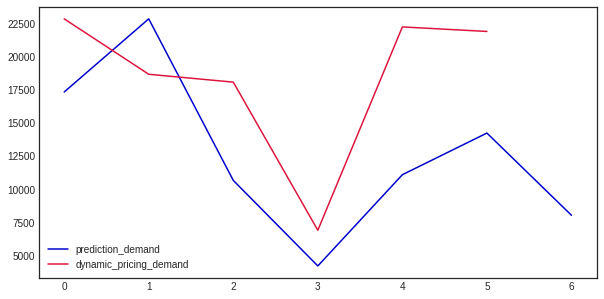

In [ ]:
result_demand = result_demand[1:]
print(p_trace[list_profit.index(max(list_profit))])


fig = plt.figure(figsize=(10, 5))
plt.plot(q_0, label="prediction_demand", color = 'mediumblue')
plt.plot(result_demand, label="dynamic_pricing_demand", color = 'crimson')
plt.legend()
plt.show

In [ ]:
# Render and save the animation of the simulation process
# !apt install imagemagick

plt.ioff()
fig = plt.figure(figsize=(16, 5))
def animate(t):
    fig.clear()
    plot_price_schedules(p_trace[0:t], 5, 1, fig.number)

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=range(10, 1000, 10), interval=50, blit=False, repeat_delay=500)
# ani.save('sim.gif', dpi=80, writer='imagemagick', fps=20)
rc('animation', html='jshtml')

<Figure size 1152x360 with 0 Axes>

Optimal price action 2500


<BarContainer object of 11 artists>

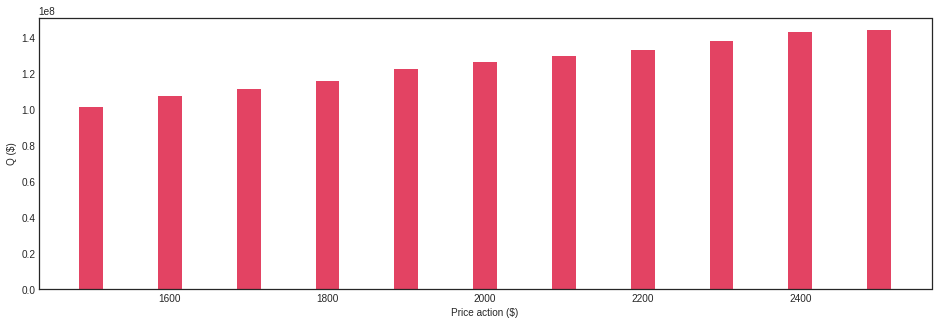

In [ ]:
# Visualize Q values for a given state
sample_state = [2600.,   0.,   0.,   0.,   0.,   0.,   0.,   \
                1.,     0.,   0.,   0.,   0.,   0.,   0.,  ]
Q_s = policy_net(to_tensor(sample_state))
a_opt = Q_s.max(0)[1].detach()
print(f'Optimal price action {price_grid[a_opt]}')

plt.figure(figsize=(16, 5))
plt.xlabel("Price action ($)")
plt.ylabel("Q ($)")
plt.bar(price_grid, Q_s.detach().numpy(), color='crimson',  width= 30, alpha=0.8)

In [ ]:
# Debugging Q-values computations

transitions = memory.sample(10)
batch = Transition(*zip(*transitions))

non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

state_batch = torch.stack(batch.state)
action_batch = torch.cat(batch.action)
reward_batch = torch.stack(batch.reward)

state_action_values = policy_net(state_batch).gather(1, action_batch)

next_state_values = torch.zeros(len(transitions), device=device)
next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

expected_state_action_values = (next_state_values * GAMMA) + reward_batch[:, 0]

q_trace = []
for t in range(len(transitions)):
    print(f"Q_(s,a)[ {expected_state_action_values[t]} ] = r [ {reward_batch[t].item()} ] + g*Q_(s+1)[ {next_state_values[t]} ]  <> Q_(s,a)[ {state_action_values[t].item()} ]")
    q_trace.append([f"Sample {t}", state_action_values[t].item(), [reward_batch[t].item(), next_state_values[t]]])

Q_(s,a)[ 159461792.0 ] = r [ 21489000.0 ] + g*Q_(s+1)[ 137972784.0 ]  <> Q_(s,a)[ 159459296.0 ]
Q_(s,a)[ 136491712.0 ] = r [ 34222500.0 ] + g*Q_(s+1)[ 102269208.0 ]  <> Q_(s,a)[ 138409696.0 ]
Q_(s,a)[ 159461792.0 ] = r [ 21489000.0 ] + g*Q_(s+1)[ 137972784.0 ]  <> Q_(s,a)[ 159459296.0 ]
Q_(s,a)[ 104052200.0 ] = r [ 28537222.0 ] + g*Q_(s+1)[ 75514976.0 ]  <> Q_(s,a)[ 102568096.0 ]
Q_(s,a)[ 159461792.0 ] = r [ 21489000.0 ] + g*Q_(s+1)[ 137972784.0 ]  <> Q_(s,a)[ 159459296.0 ]
Q_(s,a)[ 75726112.0 ] = r [ 14625600.0 ] + g*Q_(s+1)[ 61100508.0 ]  <> Q_(s,a)[ 73430848.0 ]
Q_(s,a)[ 99633848.0 ] = r [ 24229400.0 ] + g*Q_(s+1)[ 75404448.0 ]  <> Q_(s,a)[ 100137632.0 ]
Q_(s,a)[ 77343744.0 ] = r [ 17051880.0 ] + g*Q_(s+1)[ 60291860.0 ]  <> Q_(s,a)[ 75012880.0 ]
Q_(s,a)[ 4203100.0 ] = r [ 4203100.0 ] + g*Q_(s+1)[ 0.0 ]  <> Q_(s,a)[ 15914938.0 ]
Q_(s,a)[ 12013500.0 ] = r [ 12013500.0 ] + g*Q_(s+1)[ 0.0 ]  <> Q_(s,a)[ 14036368.0 ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


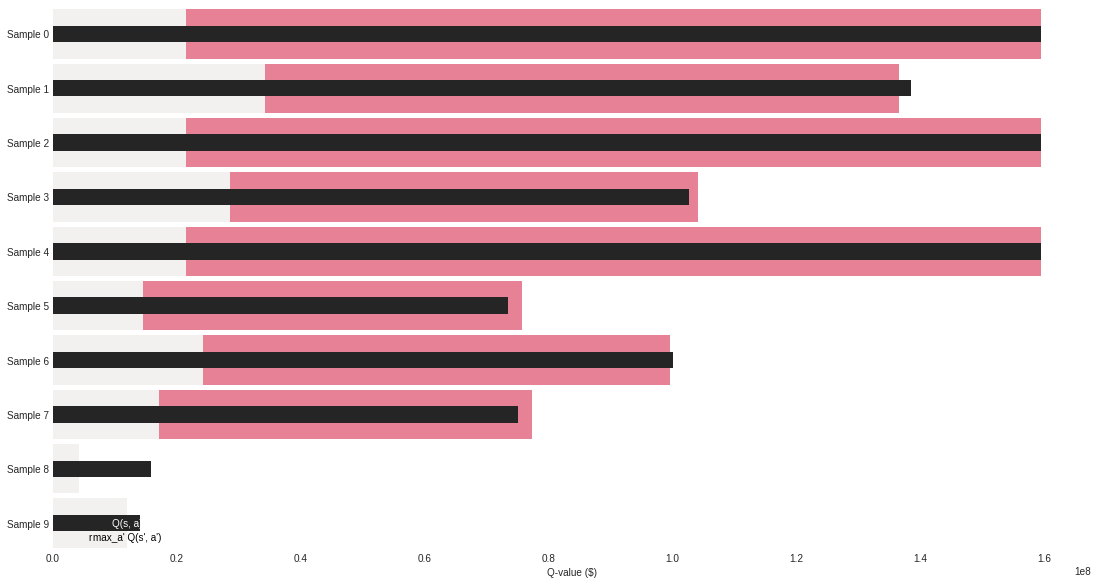

In [ ]:
# Visualization of the debugging infomation for Q-values 

palette = sns.light_palette("crimson", 3, reverse=False)
bullet_graph(np.array(q_trace),
            labels=["r", "max_a' Q(s', a')"], bar_label="Q(s, a)", size=(20, 10),
            axis_label="Q-value ($)", label_color="black",
            bar_color="#252525", palette=palette)

In [ ]:
# Playing several episods and recording Q-values with the corresponding actual retunrs

num_episodes = 100
return_trace = []
q_values_rewards_trace = np.zeros((num_episodes, T, 2, ))
for i_episode in range(num_episodes):
    state = env_intial_state()
    for t in range(T):
        # Select and perform an action
        with torch.no_grad():
            q_values = policy_net(to_tensor(state)).detach().numpy()
        action = policy.select_action(q_values)

        next_state, reward = env_step(t, state, action)

        # Move to the next state
        state = next_state

        q_values_rewards_trace[i_episode][t][0] = q_values[action]
        for tau in range(t):
            q_values_rewards_trace[i_episode][tau][1] += reward * (GAMMA ** (t - tau))

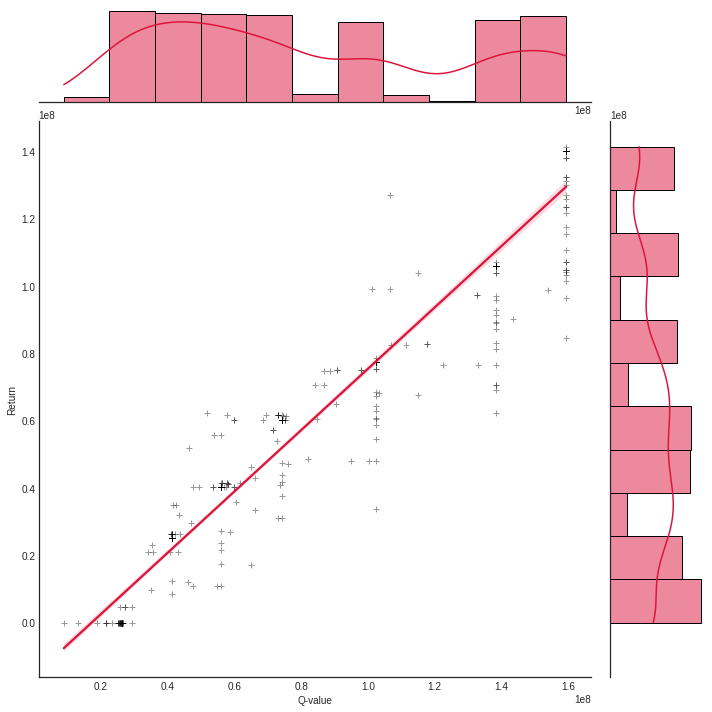

In [ ]:
# Visualizing the distribution of Q-value vs actual returns 

values = np.reshape(q_values_rewards_trace, (num_episodes * T, 2, ))

df = pd.DataFrame(data=values, columns=['Q-value', 'Return'])
g = sns.jointplot(x="Q-value", y="Return", data=df, kind="reg", color="crimson", height=10)
g.plot_joint(plt.scatter, c="k", s=30, linewidth=1, marker="+", alpha=0.4)
g.ax_joint.collections[0].set_alpha(0)